In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from made import MADE
from data.toydata import ToyDataset

from train import train_forward
from scores import log_likelihood
from scores import difference_loglik

from utils import update_device

In [3]:
from flows import create_iaf
from flows import create_maf
from flows import create_paf
from flows import create_realnvp
from flows import create_flows

In [4]:
from structure.ar import AR
from structure.iar import IAR
from structure.twoblock import TwoBlock

from transforms.affine import Affine
from transforms.piecewise import PiecewiseAffine

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [6]:
target_distr = torch.distributions.exponential.Exponential(torch.tensor([1.0]).to(device))
#target_distr = torch.distributions.gamma.Gamma(torch.tensor([1.0]).to(device), torch.tensor([5.0]).to(device))
#dataset = ToyDataset(data_distr=target_distr, dim_input=1)

dataset = ToyDataset(dim_input=100)

In [19]:
dim_input = dataset.dim_input
dim_hidden = [256,128,64,32]
num_trans = 10
perm_type = 'random'

epochs = 2
batch_size = 16

In [20]:
flows, names = [], []
#flows.append(create_iaf(dim_input, dim_hidden, num_trans, perm_type)), names.append('IAF')
#flows.append(create_maf(dim_input, dim_hidden, num_trans, perm_type)),names.append('MAF')
#flows.append(create_paf(dim_input, dim_hidden, num_trans, perm_type, structures=AR)), names.append('PAF')
#flows.append(create_realnvp(dim_input, dim_hidden, num_trans, perm_type)), names.append('Real NVP')

transformations = [Affine,PiecewiseAffine, Affine, PiecewiseAffine, Affine, PiecewiseAffine, Affine, PiecewiseAffine, Affine, PiecewiseAffine]
structures = AR
flows.append(create_flows(dim_input, dim_hidden, num_trans, perm_type, structure=structures, transformation=transformations)), names.append('PAF/IAF')

(None, None)

In [21]:
losses = []
optimizers = []
for i in range(len(flows)):
    flow = flows[i]
    update_device(device, flow, dataset)

    optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3, weight_decay=1e-2)
    #optimizer = torch.optim.SGD(flow.parameters(), lr=1e-3)
    optimizers.append(optimizer)

    losses.append(train_forward(flow, flow.get_base_distr(), dataset.get_training_data(), optimizer, epochs, batch_size, print_n=10, name=names[i]))

    update_device(device_cpu, flow, dataset)

PAF/IAF 1    212.11458


In [ ]:
#Additional training with same optimizer
for i in range(len(flows)):
    flow = flows[i]
    update_device(device, flow, dataset)

    optimizer = optimizers[i]

    losses.append(train_forward(flow, flow.get_base_distr(), dataset.get_training_data(), optimizer, epochs, batch_size, print_n=10, name=names[i]))

    update_device(device_cpu, flow, dataset)

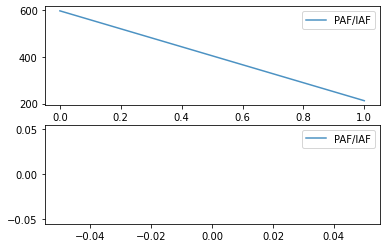

In [22]:
plt.subplot(2,1,1)
for i in range(len(losses)):
    plt.plot(losses[i], label=names[i], alpha=0.8)
plt.legend()

plt.subplot(2,1,2)
for i in range(len(losses)):
    plt.plot((losses[i])[20:], label=names[i], alpha=0.8)
plt.legend()

In [23]:
train_data = dataset.get_training_data()

In [13]:
losses[0][-1], losses[1][-1]

(tensor(26.2597, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(42.5383, device='cuda:0', grad_fn=<DivBackward0>))

In [25]:
print('Results based on training data:' + '\n')
for i in range(len(flows)):
    log_lik, mean = log_likelihood(train_data, flows[i])
    print("Mean loglikelihood for " + names[i] + ":" + str(mean))
    
    log_lik_diff, mean_diff = difference_loglik(train_data, dataset, flows[i])
    print("Mean difference from target loglikelihood for " + names[i] + ":" + str(mean_diff) + '\n')
    
mean = torch.mean(dataset.evaluate(train_data)).detach().numpy()
print("Mean loglikelihood with actual distribution:" + str(mean))
    

Results based on training data:

Mean loglikelihood for PAF/IAF:[-185.8277]
Mean difference from target loglikelihood for PAF/IAF:[121.34539]

Mean loglikelihood with actual distribution:-64.48231


In [ ]:
print('Results based on new sample from each flow:' + '\n')

for i in range(len(flows)):
    with torch.no_grad():
        sample, log_prob = flow.sample(800)
        sample_last = sample[-1]
        
    log_lik, mean = log_likelihood(sample_last, flows[i])
    print("Mean loglikelihood for " + names[i] + ":" + str(mean))
    
    log_lik_diff, mean_diff = difference_loglik(sample_last, dataset, flows[i])
    print("Mean difference from target loglikelihood for " + names[i] + ":" + str(mean_diff) + '\n')

    mean = torch.mean(dataset.evaluate(sample_last)).detach().numpy()
    print("Mean loglikelihood with actual distribution:" + str(mean))    